In [ ]:
!pip install --upgrade google-meridian[colab,and-cuda]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 705.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 813.6/813.6 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.7/590.7 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.6/412.6 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 61.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.0/22.0 MB 71.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.9/24.9 MB 74.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 867.7/867.7 kB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 704.7/704.7 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.8/98.8 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import IPython

from meridian import constants
from meridian.data import load
from meridian.data import test_utils
from meridian.model import model
from meridian.model import spec
from meridian.model import prior_distribution
from meridian.analysis import optimizer
from meridian.analysis import analyzer
from meridian.analysis import visualizer
from meridian.analysis import summarizer
from meridian.analysis import formatter

# check if GPU is available
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num CPUs Available: ", len(tf.config.experimental.list_physical_devices('CPU')))

Your runtime has 13.6 gigabytes of available RAM

Num GPUs Available:  0
Num CPUs Available:  1


In [ ]:
# To visualize all columns
pd.set_option('display.max_columns', None)

In [ ]:
df = pd.read_csv('mmm_synthetic_data_2.csv')

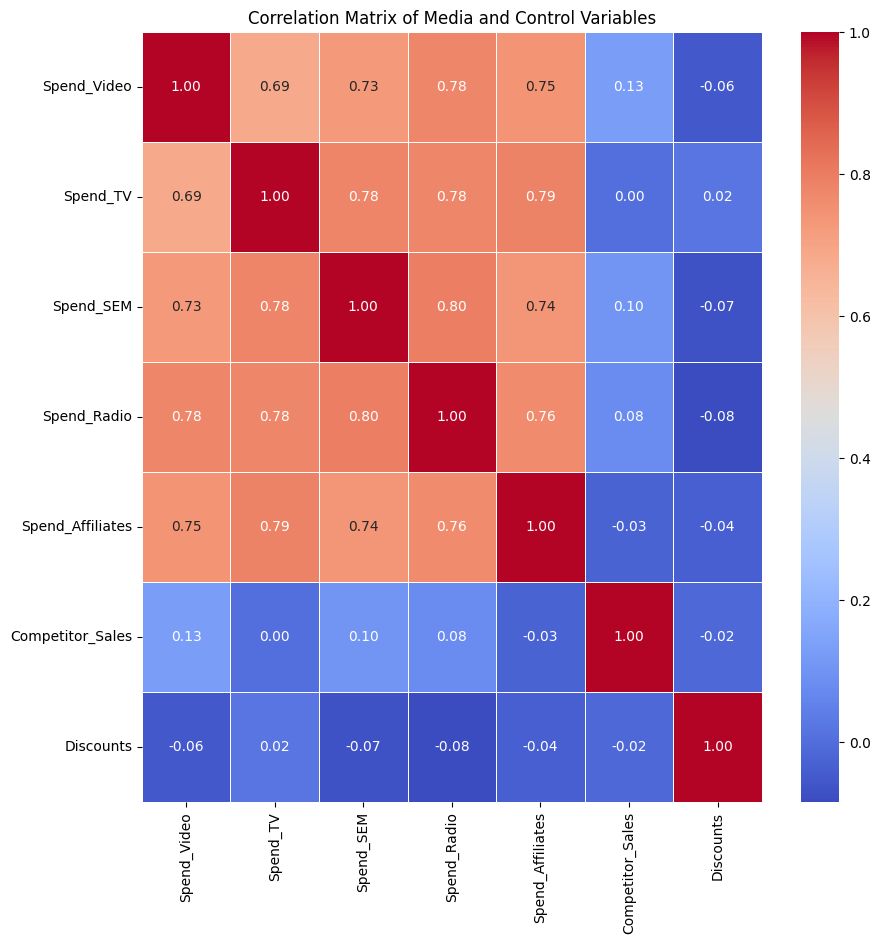

In [ ]:
# Check correlation between channels
correlation_matrix = df[['Spend_Video', 'Spend_TV', 'Spend_SEM', 'Spend_Radio', 'Spend_Affiliates', 'Competitor_Sales', 'Discounts']].corr()

# Plot heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Media and Control Variables")
plt.show()

In [ ]:
df.head()

,Date,Competitor_Sales,Discounts,Spend_Video,Impressions_Video,Spend_TV,Impressions_TV,Spend_SEM,Impressions_SEM,Spend_Radio,Impressions_Radio,Spend_Affiliates,Impressions_Affiliates,Revenue,Baseline_Revenue,Conversions,Revenue_per_Conversion,Reach_TV,Frequency_TV
0,2019-01-01,185624.772865,7376.375440,52992.657981,1.431844e+06,46240.085469,1.152125e+06,26078.422439,653330.296848,18560.396808,549790.979142,9142.848345,220783.284907,591451.494004,473161.195203,2876.184311,205.637550,144717.501408,2.455708
1,2019-01-31,194430.230700,12282.163486,58801.591536,1.588800e+06,38600.788052,9.617834e+05,30137.549062,755021.662876,23902.846444,708043.555672,11840.292593,285921.694671,597659.980940,478127.984752,2086.275396,286.472238,120808.807825,2.416482
2,2019-03-02,166809.950780,8677.831327,56522.896961,1.527230e+06,40419.680637,1.007103e+06,30607.264818,766789.227983,20325.699156,602082.280685,9458.418781,228403.741331,619231.596298,495385.277039,2201.398465,281.290101,126501.392247,3.922624
3,2019-04-01,164113.801278,11323.058306,56206.047596,1.518669e+06,36660.531658,9.134396e+05,34347.880529,860501.091843,17602.438679,521414.606412,12969.705188,313194.970285,652381.253657,521905.002925,2174.808848,299.971767,114736.391338,2.545640
4,2019-05-01,224375.774672,11335.297108,47064.286919,1.271661e+06,46366.290764,1.155270e+06,35540.993916,890391.593279,26124.349980,773848.323577,9046.353997,218453.120572,606036.224898,484828.979918,2022.387956,299.663684,145112.485864,3.037002


In [ ]:
# Mapping the columns to their corresponding categories
coord_to_columns = load.CoordToColumns(
    time='Date',
    controls=['Discounts', 'Competitor_Sales'],
    kpi='Conversions',
    revenue_per_kpi='Revenue_per_Conversion',
    media=[
        'Impressions_Video',
        'Impressions_SEM',
        'Impressions_Radio',
        'Impressions_Affiliates'
    ],
    media_spend=[
        'Spend_Video',
        'Spend_SEM',
        'Spend_Radio',
        'Spend_Affiliates'
    ],
    reach =['Reach_TV'],
    frequency=['Frequency_TV'],
    rf_spend=['Spend_TV'],
)

In [ ]:
  # Mapping the channel to their spends and impressions
  correct_media_to_channel = {
    'Impressions_Video': 'Video',
    'Impressions_SEM': 'SEM',
    'Impressions_Radio': 'Radio',
    'Impressions_Affiliates': 'Affiliates'
}
correct_media_spend_to_channel = {
    'Spend_Video': 'Video',
    'Spend_SEM': 'SEM',
    'Spend_Radio': 'Radio',
    'Spend_Affiliates': 'Affiliates'
}

correct_reach_to_channel = {
    'Reach_TV': 'TV'
}
correct_frequency_to_channel = {
    'Frequency_TV': 'TV'
}
correct_rf_spend_to_channel = {
    'Spend_TV': 'TV'
}

In [ ]:
# Loading the mapping onto their loader
loader = load.CsvDataLoader(
    csv_path=f'/content/mmm_synthetic_data_2.csv',
    kpi_type='non_revenue',
    coord_to_columns=coord_to_columns,
    media_to_channel=correct_media_to_channel,
    media_spend_to_channel=correct_media_spend_to_channel,
    reach_to_channel=correct_reach_to_channel,
    frequency_to_channel=correct_frequency_to_channel,
    rf_spend_to_channel=correct_rf_spend_to_channel,
)
data = loader.load()

/usr/local/lib/python3.11/dist-packages/meridian/data/load.py:1020: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.df[geo_column_name] = self.df[geo_column_name].replace(
/usr/local/lib/python3.11/dist-packages/meridian/data/load.py:201: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if (constants.GEO) not in self.dataset.dims.keys():
/usr/local/lib/python3.11/dist-packages/meridian/data/load.py:206: UserWarning: The `population` argument is ignored in a nationally aggregated model. It will be reset to [1]
  warnings.warn(
/usr/local/lib/python3.11/dist-pac

In [ ]:
# Setting priors
roi_mu = 0.2     # Mu for ROI prior for each media channel.
roi_sigma = 0.9  # Sigma for ROI prior for each media channel.

prior = prior_distribution.PriorDistribution(
    roi_m=tfp.distributions.LogNormal(roi_mu, roi_sigma, name=constants.ROI_M)
)
model_spec = spec.ModelSpec(prior=prior)

mmm = model.Meridian(input_data=data, model_spec=model_spec)

/usr/local/lib/python3.11/dist-packages/meridian/model/model.py:67: UserWarning: In a nationally aggregated model, the `media_effects_dist` will be reset to `normal`.
  warnings.warn(


In [ ]:
%%time
# MCMC sampling for prior and posterior
mmm.sample_prior(500)
mmm.sample_posterior(n_chains=7, n_adapt=500, n_burnin=500, n_keep=1000)

/usr/local/lib/python3.11/dist-packages/meridian/model/prior_distribution.py:846: UserWarning: Hierarchical distribution parameters must be deterministically zero for national models. tau_g_excl_baseline has been automatically set to Deterministic(0).
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/meridian/model/prior_distribution.py:846: UserWarning: Hierarchical distribution parameters must be deterministically zero for national models. eta_m has been automatically set to Deterministic(0).
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/meridian/model/prior_distribution.py:846: UserWarning: Hierarchical distribution parameters must be deterministically zero for national models. eta_rf has been automatically set to Deterministic(0).
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/meridian/model/prior_distribution.py:846: UserWarning: Hierarchical distribution parameters must be deterministically zero for national models. eta_om has been automatically set to

CPU times: user 8min 7s, sys: 35 s, total: 8min 42s
Wall time: 9min 19s


/usr/local/lib/python3.11/dist-packages/arviz/data/inference_data.py:157: UserWarning: trace group is not defined in the InferenceData scheme
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/data/inference_data.py:1655: UserWarning: trace group is not defined in the InferenceData scheme
  warnings.warn(


In [ ]:
# R-Hat  plots for the coefficients
model_diagnostics = visualizer.ModelDiagnostics(mmm)
model_diagnostics.plot_rhat_boxplot()

/usr/local/lib/python3.11/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.LayerChart(...)

In [ ]:
# Model Fit visualization
model_fit = visualizer.ModelFit(mmm)
model_fit.plot_model_fit()

/usr/local/lib/python3.11/dist-packages/meridian/analysis/analyzer.py:182: UserWarning: The `aggregate_geos` argument is ignored in the national model. It will be reset to `True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/usr/local/lib/python3.11/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.LayerChart(...)

In [ ]:
# Defining summarizer
mmm_summarizer = summarizer.Summarizer(mmm)

In [ ]:
# Connecting Drive to store summarizer
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Save the summary
from datetime import datetime

filepath = '/content/drive/MyDrive'
start_date = datetime.strptime('2019-01-01', '%Y-%m-%d').date()
end_date = datetime.strptime('2023-11-06', '%Y-%m-%d').date()
mmm_summarizer.output_model_results_summary('summary_output.html', filepath, start_date, end_date)

/usr/local/lib/python3.11/dist-packages/meridian/analysis/analyzer.py:182: UserWarning: The `aggregate_geos` argument is ignored in the national model. It will be reset to `True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/usr/local/lib/python3.11/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/usr/local/lib/python3.11/dist-packages/meridian/analysis/analyzer.py:182: UserWarning: The `aggregate_geos` argument is ignored in the national model. It will be reset to `True`.
  w

In [ ]:
# Show the summary
IPython.display.HTML(filename='/content/drive/MyDrive/summary_output.html')

Dataset,R-squared,MAPE,wMAPE
All Data,0.63,11%,10%


In [ ]:
%%time
# Define budget optimizer
budget_optimizer = optimizer.BudgetOptimizer(mmm)
optimization_results = budget_optimizer.optimize()

CPU times: user 6min 34s, sys: 9.43 s, total: 6min 43s
Wall time: 5min 52s


In [ ]:
# Defining path to store budget optimizer
filepath = '/content/drive/MyDrive'
optimization_results.output_optimization_summary('optimization_output.html', filepath)

/usr/local/lib/python3.11/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/usr/local/lib/python3.11/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/usr/local/lib/python3.11/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/usr/local/lib/python3.11/dist-packages/altair/utils/core.py:384: Futu

In [ ]:
# Showing the budget optimizer
IPython.display.HTML(filename='/content/drive/MyDrive/optimization_output.html')

Channel,Non-optimized spend,Optimized spend
Video,34%,44%
TV,26%,28%
SEM,20%,14%
Radio,13%,9%
Affiliates,7%,5%
